In [2]:
import cupy as cp
import numpy as np
import cudf
import pandas as pd
import dask_cuda
import dask_cudf

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # visualization of a progress-bar
import os
import gc # garbage collector to remove left overs from GPU memory


In [26]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#   definition of the file location and data loading
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

# ******************************
# ******************************
verbose_img_save= 0   # if = 1: enables to automatically saving the plots generates
verbose_global_df= 0  # if = 1: enables comparison of missing values for the whole data set
# ******************************
# ******************************


print("definition of the file locations")
mother_folder= "/media/igor/FEM-storage-Linux/Phython_project_datasets/"
results_folder= "/media/igor/Linux_drive-A/Eigene_Dateien/Python_project/pythonProject-007_GPGPUs/results/India_air_quality_2010-2023_time-sereis"
dataset_folder= "India_air_quality_2010_2023_time-series/"
dataset_description= "stations_info.csv"

print("looping throught the folder and generation of a list with file names")
list_file_names= os.listdir(mother_folder+ dataset_folder)

print("removing the stations info file from the list of all files")
list_file_names.remove(dataset_description)

list_file_loc= np.array([])
pbar= tqdm(list_file_names, total= len(list_file_names))
for i, file in enumerate(pbar):
    list_file_loc= np.append(list_file_loc, mother_folder+ dataset_folder+ file)


print("loading a first data-set into a DataFrame")
num_ds= 10
df= pd.read_csv(list_file_loc[num_ds])
list_col_names= df.columns
df["From Date"]= pd.to_datetime(df["From Date"])
df["To Date"]= pd.to_datetime(df["To Date"])
df["running time (h)"]= df.index


df.head(7)
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

definition of the file locations
looping throught the folder and generation of a list with file names
removing the stations info file from the list of all files


100%|██████████████████████████████████████| 453/453 [00:00<00:00, 71544.97it/s]

loading a first data-set into a DataFrame


,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),AT (degree C),RF (mm),running time (h)
0,2021-03-26 09:00:00,2021-03-26 10:00:00,47.00,208.00,2.47,6.54,9.29,1.84,18.36,0.47,...,46.53,0.46,120.78,477.21,989.97,NaN,NaN,30.42,0.0,0
1,2021-03-26 10:00:00,2021-03-26 11:00:00,45.70,234.36,2.30,5.98,8.56,1.37,18.54,0.46,...,43.63,0.70,138.39,618.55,989.69,NaN,NaN,30.85,0.0,1
2,2021-03-26 11:00:00,2021-03-26 12:00:00,37.55,152.26,2.07,5.38,7.72,1.03,18.46,0.43,...,40.18,0.49,143.71,615.76,988.77,NaN,NaN,32.34,0.0,2
3,2021-03-26 12:00:00,2021-03-26 13:00:00,41.74,131.56,2.27,7.50,9.89,2.14,18.56,0.45,...,39.31,0.50,132.69,602.51,987.50,NaN,NaN,32.94,0.0,3
4,2021-03-26 13:00:00,2021-03-26 14:00:00,43.23,143.69,2.22,8.08,10.29,2.41,19.07,0.49,...,38.43,0.58,149.95,467.87,986.35,NaN,NaN,33.29,0.0,4
5,2021-03-26 14:00:00,2021-03-26 15:00:00,50.54,160.29,2.07,6.25,8.48,1.51,18.49,0.49,...,38.28,0.44,157.78,318.88,985.63,NaN,NaN,33.35,0.0,5
6,2021-03-26 15:00:00,2021-03-26 16:00:00,36.62,170.92,2.12,6.31,8.60,1.57,18.56,0.49,...,40.39,0.35,164.05,160.82,985.27,NaN,NaN,32.75,0.0,6


In [6]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#   definition of the file location and data loading
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
import glob # API to handle file-names and folder structures

# ::::::::::::::::::::::::::::::::::::::::::::::::::::
'''all DataFrames are on the GPU from this point on'''
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

print("loading the stations info into a DataFrame")
stations_df= pd.read_csv(mother_folder+ dataset_folder+ dataset_description) # loading the info about the individual stations
stations_df.drop(["agency", "station_location", "start_month"], axis= 1, inplace= True) # removing some columns from the DataFrame

print("Printing the individual states...\n")
print(stations_df.state.unique())

print("defining a function to combine all data files within one state")
def combine_DataFrame(state_name, verbose):
    '''input: state_name needs to be a string
       input: verbose==1 -> printing status feedback
       output: concatinated DataFrame'''
    DataFrame_table= [] # table containing all DataFrames to be combined

    state_df= stations_df[stations_df["state"]== state_name]["file_name"] # DataFrame of all file names within one state

    if verbose== 1: print(f"the chosen state contains {len(state_df)} stations to be combined")
    if verbose== 1: print("looping through all file locations....")
    pbar= tqdm(state_df, total= len(state_df))
    for i, city in enumerate(pbar):
        file_loc= glob.glob(mother_folder+ dataset_folder+ city+ ".csv")[0] # creating the path to the file being read into a DataFrame
        df_= cudf.read_csv(file_loc)
        df_["city"]= stations_df.loc[stations_df["file_name"]== city]["city"].values[0] # creating a column containing the source city
        df_.drop(["To Date"], axis= 1, inplace= True)
        DataFrame_table.append(df_)

    if verbose==1:
        for i in range(len(DataFrame_table)):
            print(f"{i+1}.th shape of the DataFrame included: {DataFrame_table[i].shape}")
#::::::::::::::::::::::::::::::::
    df= cudf.concat(DataFrame_table).sort_values("From Date")
    df= df.reset_index()
    df.drop(["index"], axis= 1, inplace= True)
#::::::::::::::::::::::::::::::::
    return df # cudf.concat(DataFrame_table)


# ::::::::::::::::::::::::::::::::::::::::::::::::::::

loading the stations info into a DataFrame
Printing the individual states...

['Andhra Pradesh' 'Arunachal Pradesh' 'Assam' 'Bihar' 'Chhattisgarh'
 'Chandigarh' 'Delhi' 'Gujarat' 'Himachal Pradesh' 'Haryana' 'Jharkhand'
 'Jammu and Kashmir' 'Karnataka' 'Kerala' 'Maharashtra' 'Meghalaya'
 'Manipur' 'Madhya Pradesh' 'Mizoram' 'Nagaland' 'Odisha' 'Punjab'
 'Puducherry' 'Rajasthan' 'Sikkim' 'Telangana' 'Tamil Nadu' 'Tripura'
 'Uttarakhand' 'Uttar Pradesh' 'West Bengal']
defining a function to combine all data files within one state


In [8]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#       data loading and state-wise combining
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

state= "Assam"

print("picking one state as example", state)
df_state= combine_DataFrame(state, 0) # enter: state name, verbose: 0 to skip status outputs

print(df_state.head(5))

print("\n"+ f"shape of the aggregated DataFrame {df_state.shape}")

# ::::::::::::::::::::::::::::::::::::::::::::::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

picking one state as example Assam


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 27.61it/s]

             From Date  PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
0  2019-03-01 00:00:00          84.50        122.29       17.16        10.45   
1  2019-03-01 01:00:00          46.73         58.81       12.54         9.09   
2  2019-03-01 02:00:00          40.54         53.46       11.16         8.20   
3  2019-03-01 03:00:00          52.62         64.58       11.25         7.26   
4  2019-03-01 04:00:00          43.21         62.12       15.26         7.11   

   NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  Ozone (ug/m3)  ...  \
0      39.49        27.07        14.86        0.86          15.77  ...   
1      30.37        25.94        14.58        0.59          16.33  ...   
2      27.12        24.55        14.58        0.49          12.95  ...   
3      26.19        23.66        14.52        0.50          13.81  ...   
4      32.71        21.36        14.96        0.55          12.55  ...   

   RH (%)  WS (m/s)  WD (degree)  SR (W/mt2) BP (mmHg)  AT (degree C)  \
0

In [10]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#  redefining index and getting an idea about data quality
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

print("defining a function to set a datetime and use it as index")
def set_datetime_index(DataFrame):
    DataFrame["From Date"]= cudf.to_datetime(DataFrame["From Date"])
    DataFrame= DataFrame.rename(columns= {"From Date": "datetime"})
    return DataFrame


print("defining a function to average over multiple stations within one state")
def average_DataFrame(df, verbose):
    '''input: DataFrame thats entries will get grouped by time and averaged
       input: verbose== 1; enables status messages
       output: grouped and sorted DataFrame comprising averaged values'''
    DataFrame= df.copy() # get a copy of the original DataFrame
    DataFrame= DataFrame.drop(["city"], axis= 1) # drop city column for mean-calculation
    start, end= DataFrame["datetime"].index[0], DataFrame["datetime"].index[-1]
    
    time_stamps= cudf.Series(DataFrame["datetime"].unique())       # unique dates
    date_counts= DataFrame["datetime"].value_counts().sort_index() # check the number of entries per date/time_stamp
    single= len(date_counts[date_counts<2])                        # number of single entries per date/time_stamp in the DataFrame
    
    if verbose== 1: print("starting at:", start, " and ending at: ", end, "\n",
                          f"there are {single} single entries in the DataFrame")

    return DataFrame.groupby("datetime").mean().sort_index()


print("defining a function to check the usability of the data aquired")
def nan_percentage(DataFrame):
    # summing all NaN values, soring them and getting the missing in percentage
    nan_series= DataFrame.isna().sum().sort_values(ascending= False)/len(df_state)*100
    # definition of the figure to be plottet
    fig, ax= plt.subplots(1,1, figsize= (12,int(len(nan_series)/4)))
    sns.barplot(nan_series.to_pandas(), orient= "y")
    plt.grid()
    return plt.show()
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

defining a function to set a datetime and use it as index
defining a function to average over multiple stations within one state
defining a function to check the usability of the data aquired


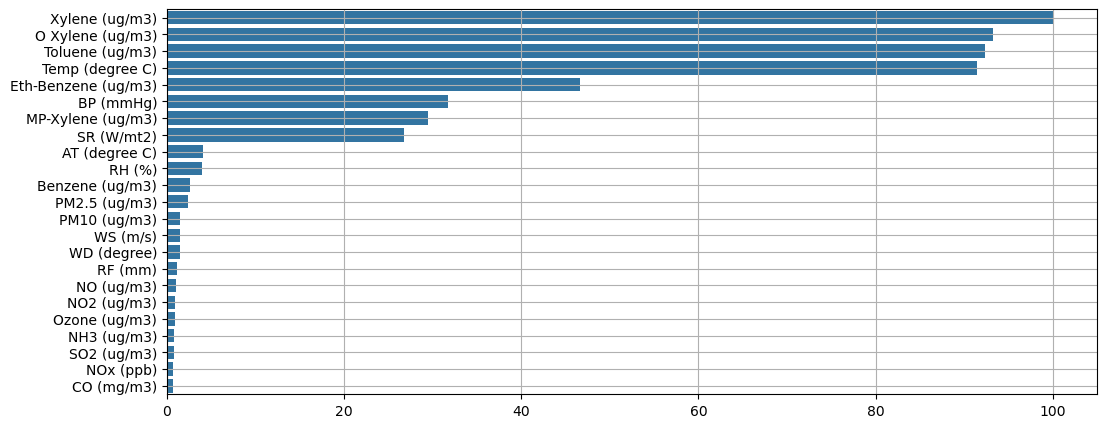

In [12]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#  redefining index and getting an idea about data quality
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

df_state= set_datetime_index(df_state)
df_state= average_DataFrame(df_state, 0)

nan_percentage(df_state)

# ::::::::::::::::::::::::::::::::::::::::::::::::::::

In [16]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#    getting a feeling about all metrics measured
# ::::::::::::::::::::::::::::::::::::::::::::::::::::


if verbose_global_df== 1:
    df_all= [] # empty table to sum up all the DataFrames of the data-sets/
    print("looping throught all data files to get a complete DataFrame")
    pbar= tqdm(list_file_loc, total= len(list_file_loc))
    for loc in pbar:
        df_= cudf.read_csv(loc)
        df_all.append(df_)

    print("reshaping the data")
    df_all= cudf.concat(df_all)

    print("generating a visualization of the percentage of missing values")
    nan_percentage(df_all)


# ::::::::::::::::::::::::::::::::::::::::::::::::::::

In [18]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#   determination of important air pollution metrics
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

# according to https://waqi.info/ the main indicators for air pollution are:
# Ozone, PM2.5, PM10, NOx, SO2 and CO

print("definition of the main important metrics to determine air pollution")
metrics= ["Ozone (ug/m3)", "NOx (ug/m3)", "SO2 (ug/m3)", "CO (ug/m3)", "PM2.5 (ug/m3)", "PM10 (ug/m3)"]

print("checking for dublications and similar metrics")
# list of all similar metrics
list_similar_metrics= ["SO2 ()", "NOx (ppb)", "NOx (ppm)", "Ozone (ppb)", "Ozone ()", "CO (ng/m3)", "CO (mg/Nm3)", "CO (mg/m3)"]

if verbose_global_df==1: 
    list_metrics= df_all.columns
    print(f"the global DataFrame consists of a total of {len(list_metrics)} metrics")

print("selecting only the important metrics")
list_metrics= np.array(metrics)
list_metrics= np.append(list_metrics, list_similar_metrics)

# list of common metrics to be combined into one
list_common_metrics= {"SO2 (ug/m3)":       ["SO2 ()"],
                      "NOx (ug/m3)":       ["NOx (ppb)", "NOx (ppm)"],
                      "Ozone (ug/m3)":     ["Ozone (ppb)", "Ozone ()"],
                      "CO (ug/m3)":        ["CO (ng/m3)", "CO (mg/Nm3)", "CO (mg/m3)"]}

def combine_metrics(DataFrame, metrics, verbose):
    '''input: DataFrame
       input: metrics= the common metrics to be unified
       input: verbose==1 -> printing status feedback
       output: unified DataFrame'''
    # DataFrame= df.copy()
    if verbose== 1: print(f"unifying the metrics\n length of important metrics: {len(metrics)}")
    for column, cols_to_merge in metrics.items():
        # checking if the metric is already part of the DataFrame; if NOT, create it and fill with NaN
        if column not in DataFrame.columns and any(name in DataFrame.columns for name in cols_to_merge):
            if verbose== 1: print(f"generating an empty columns with the right definition of the metric\n metric: {column}")
            DataFrame[column]= cp.nan
        for col_name in cols_to_merge:
            # generate the desired column and fill it with the previous data
            if col_name in DataFrame.columns:
                if verbose== 1: print(f"transfering the data of the metric to its unified columns definition\n {col_name} -> {column}")
                if col_name== "NOx (ppm)": DataFrame[column]= DataFrame[column].fillna(10* DataFrame[col_name])
                else: DataFrame[column]= DataFrame[column].fillna(DataFrame[col_name])
                # remove the previous data from the DataFrame
                DataFrame= DataFrame.drop(columns= [col_name])
    return DataFrame


# ******************************
# ******************************
if verbose_global_df== 1:
    print("generating a global, unified DataFrame")
    df_unif= combine_metrics(df_all, list_common_metrics, 1)
    df_unif= df_unif[metrics]
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

definition of the main important metrics to determine air pollution
checking for dublications and similar metrics
selecting only the important metrics


In [ ]:
# unfyed DataFrame needs to be created first
if verbose_global_df== 1: nan_percentage(df_all[list_metrics])

In [ ]:
# unfyed DataFrame needs to be created first
if verbose_global_df== 1: nan_percentage(df_unif)

In [ ]:
# unfyed DataFrame needs to be created first
if verbose_global_df== 1: print(df_unif.describe())

In [20]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#    redefining index and combining diff. stations
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

df_state= combine_DataFrame(state, 0) # enter: state name, verbose: 0 to skip status outputs
df_state= set_datetime_index(df_state)
df_state= average_DataFrame(df_state, 0)

# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#             tackling missing values
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

print("unifying the metrics for the state being investigated")
df_state= combine_metrics(df_state, list_common_metrics, 0)
df_state= df_state[metrics]

print("defining a function to fill missing values in my DataFrame")
def fill_nan(DataFrame, verbose):
    if verbose== 1: print("filling all missing values with the average of that metric")
    metrics= DataFrame.columns.values
    if verbose==1: print(metrics)
    for metric in metrics:
        if verbose==1: print(f"{metric} has {DataFrame[metric].isna().sum()} missing values and those are filled with {DataFrame[metric].mean():.3f}")
        DataFrame[metric]= DataFrame[metric].fillna(DataFrame[metric].mean())
    return DataFrame

print("applying the fill_nan function to the DataFrame selected")
df_state= fill_nan(df_state, 0)

df_state.isna().sum()

# ::::::::::::::::::::::::::::::::::::::::::::::::::::

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 53.95it/s]


unifying the metrics for the state being investigated
defining a function to fill missing values in my DataFrame
applying the fill_nan function to the DataFrame selected


Ozone (ug/m3)    0
NOx (ug/m3)      0
SO2 (ug/m3)      0
CO (ug/m3)       0
PM2.5 (ug/m3)    0
PM10 (ug/m3)     0
dtype: int64

In [ ]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#         quick visual check of dependenceis
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

sns.pairplot(df_state.to_pandas())
plt.show()
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

In [24]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#       calculating air quality index - CPU
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

# actual break points for different metrics
M_BP= np.array([[0, 50, 100, 168, 208, 784, 785], # ozone
               [0, 40, 80, 180, 280, 400, 401], # NOx
               [0, 40, 80, 380, 800, 1600, 1601], # SO2
               [0, 1, 2, 10, 17, 34, 35], # CO
               [0, 30, 60, 90, 120, 250, 251], # PM2.5
               [0, 50, 100, 250, 350, 430, 431]]) # PM10

# AQI coresponging to the break points defined above
v_BP=np.array([0, 50, 100, 200, 300, 400, 401]) # actual Air Quality Index
# generating a DataFrame containing the break points and setting metrics for the columns and the AQI-values as index
df_BP= pd.DataFrame(M_BP.T, columns= metrics, index= v_BP)

# defining a function to determine the AQI
def air_index_cudf(DataFrame, df_BP):
    # input: DataFrame just containing the important metrics
    # output: cp.array containing max air quality index
    
    # i_hi/lo= AQI coresponging to BP_hi/lo
    # C = actual concentration/ measured values
    metrics= DataFrame.columns
    limits= df_BP.max().values
    max_AQI= df_BP.index[-1]
    
    array_AQI= np.array([])
    pbar= tqdm(DataFrame.values_host, total= len(DataFrame))
    for i, value in enumerate(pbar): # enumerate(DataFrame.values): # looping through the rows; each value contains the full row
        array_temp= np.array([]) # temporary array to save AQI values for each metric and to select the highest one afterwards
        
        for o, metric in enumerate(metrics): # looping throught the metrics
            # if value[o]>= df_BP[metric].max(): AQI= df_BP.index[-1] # setting AQI to its max value
            if value[o]>= limits[o]: AQI= max_AQI # setting AQI to its max value
            else:
                BP_lo= df_BP[df_BP[metric]<= value[o]][metric].values[-1] # works as well with: .le(value[o])
                BP_hi= df_BP[df_BP[metric]> value[o]][metric].values[0]   # works as well with: .gt(value[o])
    
                I_lo= df_BP[df_BP[metric]<= value[o]].index[-1]
                I_hi= df_BP[df_BP[metric]> value[o]].index[0]

                AQI= (I_hi- I_lo)/ (BP_hi- BP_lo)* (value[o]- BP_lo)+ I_lo
            array_temp= np.append(array_temp, AQI)

        array_AQI= np.append(array_AQI, array_temp.max()) #saving only the highest AQI
    return cp.array(array_AQI)


''' ****************************************************************
 this is an attempt to speed up the AQI calculation just with numpy
**************************************************************** '''
limits= df_BP.max().values # max value of each metric leading to AQI.max

def air_index(DataFrame, lim, v, mat_BP): # mat_0, mat_1, mat_2, mat_3, mat_4, mat_5
    print("this computation is based on numpy")
    '''
    input: DataFrame=     DataFrame containing the values for each metric
    input: limits=        max value of each metric leading to AQI.max
    input: v=             vector of AQI break points
    input: mat=           break points for each metric

    output: cupy.array containing the max AQI value for each time step
    
    '''
    numpy_array= DataFrame.to_numpy()
    max_AQI= v.max() # setting max AQI, as limit
    len_limits= len(lim) # defines the length of the second/inner loop
    
    array_AQI= np.array([]) # empty array to save AQI.max for each time step
    pbar= tqdm(numpy_array, total= len(numpy_array))
    for value in pbar:
        
        array_temp= np.array([]) # empty array to save the metric dependend AQI values
        for o in range(len_limits):
            if value[o]> lim[o]: AQI= max_AQI # setting AQI to its max value
            else:
                BP_lo= np.extract( mat_BP[o]<= value[o], mat_BP[o]).max()
                BP_hi= np.extract( mat_BP[o]> value[o], mat_BP[o]).min()

                ind_lo= np.where(mat_BP[o]<= value[o])[0].max() # getting the location of lower break point
                ind_hi= np.where(mat_BP[o]> value[o])[0].min() # getting the location of upper break point

                I_lo= v[ind_lo] # getting lower AQI break point based on metric break point
                I_hi= v[ind_hi] # getting upper AQI break point based on metric break point

                AQI= (I_hi- I_lo)/ (BP_hi- BP_lo)* (value[o]- BP_lo)+ I_lo
            array_temp= np.append(array_temp, AQI)
        array_AQI= np.append(array_AQI, array_temp.max()) #saving only the highest AQI
    return cp.array(array_AQI)


print("adding AQI in my DataFrame...")
df_state["AQI"]= air_index(df_state, limits, v_BP, M_BP) # this results in about 4500 it/s with normal Pandas

df_state.head(5)

# ::::::::::::::::::::::::::::::::::::::::::::::::::::

adding AQI in my DataFrame...
this computation is based on numpy


100%|███████████████████████████████████| 35808/35808 [00:07<00:00, 4912.59it/s]


,Ozone (ug/m3),NOx (ug/m3),SO2 (ug/m3),CO (ug/m3),PM2.5 (ug/m3),PM10 (ug/m3),AQI
datetime,,,,,,,
2019-03-01 00:00:00,15.77,39.49,14.86,0.86,84.50,122.29,181.666667
2019-03-01 01:00:00,16.33,30.37,14.58,0.59,46.73,58.81,77.883333
2019-03-01 02:00:00,12.95,27.12,14.58,0.49,40.54,53.46,67.566667
2019-03-01 03:00:00,13.81,26.19,14.52,0.50,52.62,64.58,87.700000
2019-03-01 04:00:00,12.55,32.71,14.96,0.55,43.21,62.12,72.016667


setting up the details for my figure
lopping through all metrics and generate yearly aggeration plots


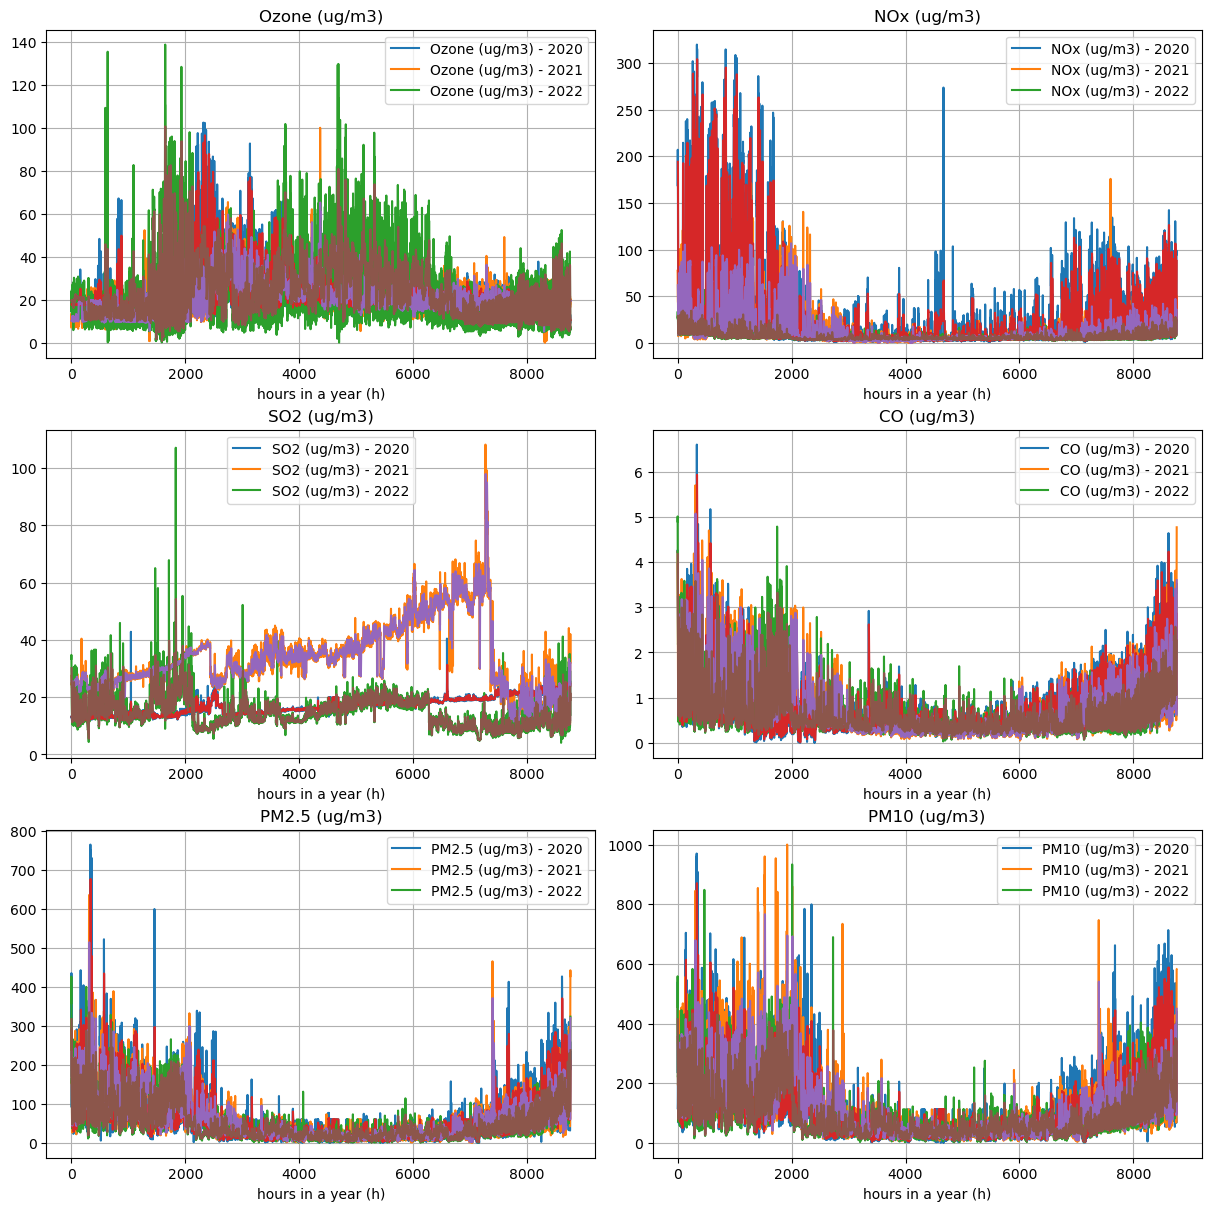

In [28]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#   a quick check for outliers in the data set - 1
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

print("setting up the details for my figure")
fig, axs = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True)
years= df_state.index.year.unique().values.get()
years_= np.delete(years, [0, -1]) # removing first and last year, since thay are not complete; we might need a better idea ;)

# ******************************
# ******************************
verbose_roll_mean= 1
roll= 6
# ******************************
# ******************************

print("lopping through all metrics and generate yearly aggeration plots")
for ax, metric in zip(axs.flat, metrics):
    ax.set_title(metric)
    ax.set_xlabel("hours in a year (h)")
    ax.grid()
    data= cp.array([]) # an empty array to store the yearly data from a specofic metric - a DataFrame will be from it created afterwards
    data= [cp.append(data, df_state[df_state.index.year== year][metric]).get() for year in years_]
    # 0, -24 for 'Assam'; not for 'Tripura'
    data[0]= np.delete(data[0], range(-24, 0)) # not all years have the same amount of data - demoving one day to make them equal in length
    data= np.array(data).T # transposing the data to get rows = number of years
    data= pd.DataFrame(data, columns= [metric+ " - "+ str(year) for year in years_], index= range(365* 24))
    if verbose_roll_mean==1: 
        data_= data.copy()
        data_= data_.rolling(roll).mean()
    ax.plot(data.index, data, label= data.columns)
    if verbose_roll_mean==1: ax.plot(data_.index, data_, label= data_.columns)
    ax.legend(data.columns)

if verbose_img_save== 1: plt.savefig(results_folder+ f"/001_yearly_comparison_of_metrics_for_{state}.pdf", bbox_inches="tight", transparent=True)
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

In [30]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#   generating a DataFrame containing roll.mean
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

# ******************************
# ******************************
roll_df= 6     # define the hours for rolling average
outlier= 1000  # define the hours for outlier detection
sigma= 3       # define the total sigmas to be taken into account for outlier detection
# ******************************
# ******************************

print("getting a copy of my original DataFrame")
df_roll= cudf.DataFrame(df_state[metrics])
df_roll_clean= cudf.DataFrame([]) # generating an empty DataFrame for data storage after outlier removal
df_stats_all= cudf.DataFrame([])

print(f"checking for outliers in a bucket of {outlier} h")
pbar= tqdm((range(1+ int(len(df_roll)/ outlier))))
for i in pbar:
    start, stop= i* outlier, (i+1)* outlier
    if stop> len(df_roll): stop= len(df_roll) # setting an upper limit
    df_outlier= df_roll.iloc[start: stop]
    df_stats= cudf.DataFrame([df_outlier.mean(), df_outlier.std()], index= [f"mean_{i}", f"std_{i}"])

    for metric in metrics:
        df_outlier[metric]= df_outlier[metric].mask(df_outlier[metric].gt(df_stats[metric].loc[f"mean_{i}"]+ sigma* df_stats[metric].loc[f"std_{i}"]))
    df_roll_clean= cudf.concat([df_roll_clean, df_outlier])
    df_stats_all= cudf.concat([df_stats_all, df_stats])

df_roll= df_roll_clean.ffill() # overwriting the old data with the cleaned DataFrame

print(f"generating a rolling average of {roll} h")
df_roll= df_roll.rolling(roll_df).mean()
df_roll= df_roll.iloc[roll:]


print("calculating air quality index...")
df_roll["AQI"]= air_index(df_roll, limits, v_BP, M_BP) # this results in about 225 - 250 it/s with normal Pandas


df_roll.head(5)

# ::::::::::::::::::::::::::::::::::::::::::::::::::::

getting a copy of my original DataFrame
checking for outliers in a bucket of 1000 h


100%|███████████████████████████████████████████| 36/36 [00:02<00:00, 16.57it/s]


generating a rolling average of 6 h
calculating air quality index...
this computation is based on numpy


100%|███████████████████████████████████| 35802/35802 [00:07<00:00, 4852.67it/s]


,Ozone (ug/m3),NOx (ug/m3),SO2 (ug/m3),CO (ug/m3),PM2.5 (ug/m3),PM10 (ug/m3),AQI
datetime,,,,,,,
2019-03-01 06:00:00,13.605000,41.355000,14.835000,0.576667,47.201667,62.963333,78.669444
2019-03-01 07:00:00,13.433333,50.535000,14.900000,0.593333,53.265000,70.981667,88.775000
2019-03-01 08:00:00,14.543333,57.793333,15.093333,0.616667,56.655000,75.936667,94.425000
2019-03-01 09:00:00,17.990000,59.616667,15.606667,0.618333,57.558333,79.146667,95.930556
2019-03-01 10:00:00,21.680000,57.906667,16.140000,0.605000,60.166667,81.835000,100.555556


In [ ]:
df_roll.shape, df_state.shape

In [ ]:
len(data), len(data_), len(data_[0]), len(data_[1]), len(data_[2])

setting up the details for my figure
lopping through all metrics and generate yearly aggeration plots


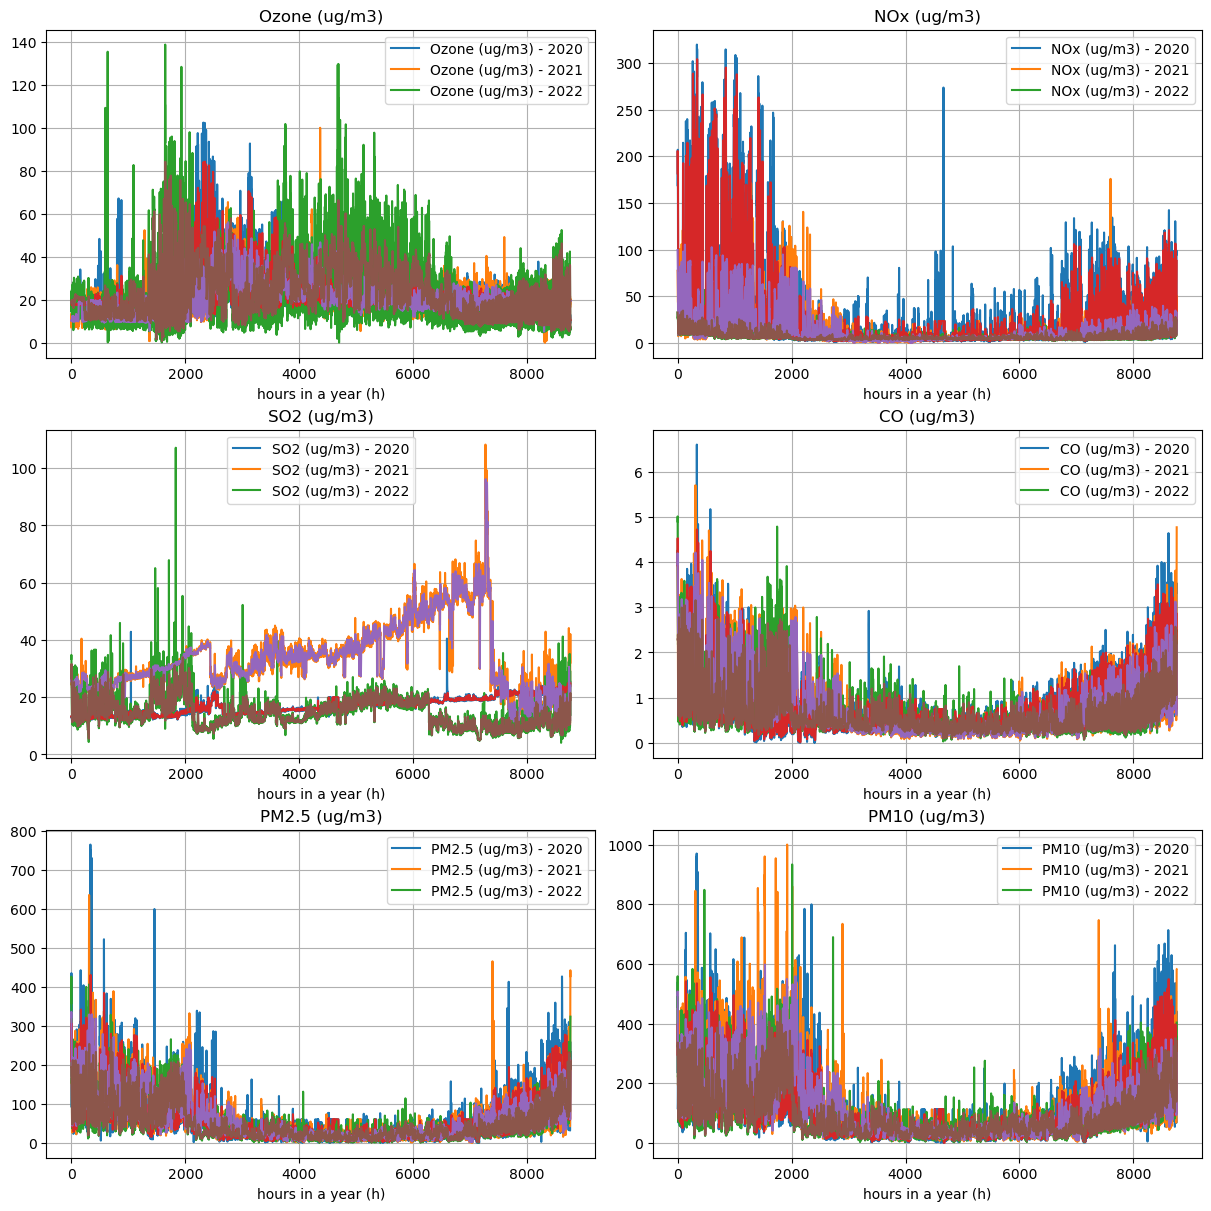

In [32]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#        we should make a function out of it
# ::::::::::::::::::::::::::::::::::::::::::::::::::::


print("setting up the details for my figure")
fig, axs = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True)
years= df_state.index.year.unique().values.get()
years_= np.delete(years, [0, -1]) # removing first and last year, since thay are not complete; we might need a better idea ;)

# ******************************
# ******************************
verbose_roll_mean= 1
# ******************************
# ******************************

print("lopping through all metrics and generate yearly aggeration plots")
for ax, metric in zip(axs.flat, metrics):
    ax.set_title(metric)
    ax.set_xlabel("hours in a year (h)")
    ax.grid()
    data= cp.array([]) # an empty array to store the yearly data from a specofic metric - a DataFrame will be from it created afterwards
    data= [cp.append(data, df_state[df_state.index.year== year][metric]).get() for year in years_]
    # 0, -24 for 'Assam'; not for 'Tripura'
    data[0]= np.delete(data[0], range(-24, 0)) # not all years have the same amount of data - demoving one day to make them equal in length
    data= np.array(data).T # transposing the data to get rows = number of years
    data= pd.DataFrame(data, columns= [metric+ " - "+ str(year) for year in years_], index= range(365* 24))
    if verbose_roll_mean==1: 
        data_= cp.array([])
        data_= [cp.append(data_, df_roll[df_roll.index.year== year][metric]).get() for year in years_]
        # 0, -24 for 'Assam'; not for 'Tripura'
        data_[0]= np.delete(data_[0], range(-24, 0)) # not all years have the same amount of data - demoving one day to make them equal in length
        data_= np.array(data_).T # transposing the data to get rows = number of years
        data_= pd.DataFrame(data_, columns= [metric+ " - "+ str(year) for year in years_], index= range(365* 24))
    ax.plot(data.index, data, label= data.columns)
    if verbose_roll_mean==1: ax.plot(data_.index, data_, label= data_.columns)
    ax.legend(data.columns)

if verbose_img_save== 1: plt.savefig(results_folder+ f"/002_yearly_comparison_of_metrics_for_{state}_rolling-mean_{roll}h.pdf", bbox_inches="tight", transparent=True)
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

setting up my image definitions


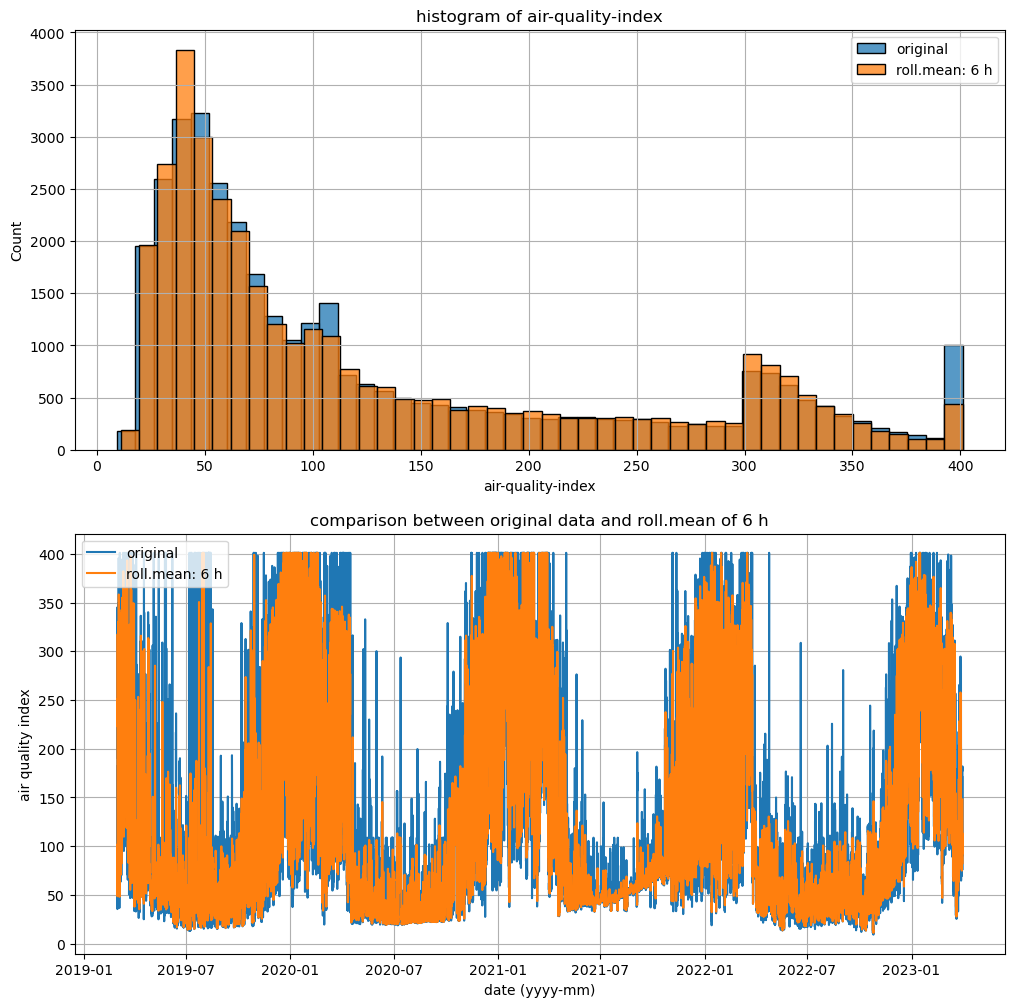

In [34]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#   a quick check for outliers in the data set - 2
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

print("setting up my image definitions")
fig, axn= plt.subplots(2,1 ,figsize= (12,12))
sns.histplot(df_state["AQI"].to_numpy(), ax= axn[0], label= "original")
sns.histplot(df_roll["AQI"].to_numpy(), ax= axn[0], label= f"roll.mean: {roll} h")
sns.lineplot(x= df_state.index.to_numpy(), y= df_state["AQI"].to_numpy(), ax= axn[1], label= "original")
sns.lineplot(x= df_roll.index.to_numpy(), y= df_roll["AQI"].to_numpy(), ax= axn[1], label= f"roll.mean: {roll} h")

axn[0].set_title("histogram of air-quality-index")
axn[0].set_xlabel("air-quality-index")
axn[1].set_title(f"comparison between original data and roll.mean of {roll} h")
axn[1].set_xlabel("date (yyyy-mm)")
axn[1].set_ylabel("air quality index")
[axn[i].grid() for i in range(2)]
[axn[i].legend() for i in range(2)]

if verbose_img_save== 1: plt.savefig(results_folder+ f"/003_histogram_of_AQI_for_{state}_rolling-mean_{roll}h.pdf", bbox_inches="tight", transparent=True)

plt.show()
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

In [36]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#          time-based clustering and lags
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

# *********************************
# *********************************
'''definition of the metric being used for the model training - we focus on using AQI'''
metric_ml= "AQI"
df_ml= df_roll
# *********************************
# *********************************

print("defining a function to add some date features to the DataFrame")
def date_features(DataFrame):
    DataFrame["hour"]= DataFrame.index.hour
    DataFrame["dayofmonth"]= DataFrame.index.day
    DataFrame["dayofweek"]= DataFrame.index.dayofweek
    DataFrame["dayofyear"]= DataFrame.index.dayofyear
    DataFrame["weekofyear"]= DataFrame.index.isocalendar().week.astype(np.float64)
    DataFrame["month"]= DataFrame.index.month
    DataFrame["year"]= DataFrame.index.year
    return DataFrame

list_date_features= ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'year']


print("defininf a function to add some lag features to the data in the DataFrame")
def lag_feature(DataFrame, metric, periode, lags, verbose, drop_na=1):
    '''
    input: DataFrame
    input: metric to be lagged
    input: periode= weekly, monthly, yearly in days
    input: lags= the amount of lags added
    input=:verbose==1 printing status mesages
    return: DataFrame with lagged features
    return: list of lag features created
    '''
    list_lag_names= []
    for i in range(lags):
        DataFrame[metric+ "_"+ str(i)]= DataFrame[metric].shift((i+1)* periode* 24)
        list_lag_names.append(metric+ "_"+ str(i))
    if verbose== 1: print("the following lag features have been created", list_lag_names)
    if drop_na==1: DataFrame= DataFrame.dropna()
    return DataFrame, list_lag_names


print("applying the functions defined above to my DataFrame")
df_ml= date_features(df_ml)
df_lags, list_lag_features= lag_feature(df_ml, metric_ml, 365, 2, 1) # periode= 365 days; lags= 2; verbose= 1
list_lag_features.insert(0, metric_ml)                               # adding "AQI" to the Datasets

# ::::::::::::::::::::::::::::::::::::::::::::::::::::

defining a function to add some date features to the DataFrame
defininf a function to add some lag features to the data in the DataFrame
applying the functions defined above to my DataFrame
the following lag features have been created ['AQI_0', 'AQI_1']


In [38]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#      definition of the hyper parameters
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
# from cuml.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor as XGB
from cuml.ensemble import RandomForestRegressor as RFR

from cuml.model_selection import GridSearchCV

print("definition of a function to split the data into train and test samples")
def train_test_split(DataFrame, train_size, predictors, target):
    '''
    Input: DataFrame
    Imput: train_size as fraction
    Input: predictors= time features
    Input: target= metric to be predicted
    Return
    ------
    X_train (DataFrame): The training set
    X_test (DataFrame): The testing set
    y_train (Series): The y values of the training set
    y_test (Series): The y values of the testing set
        '''
    train_rows= int(len(DataFrame)* train_size)
    test_rows= int(len(DataFrame)- train_rows)
    train_set, test_set= DataFrame.iloc[:train_rows], DataFrame.iloc[train_rows+1:]    
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

print("splitting the data into train and test samples")
X_train, X_test, y_train, y_test= train_test_split(df_lags, train_size=0.65, 
                                                   predictors= list_date_features+ list_lag_features, 
                                                   target= metric_ml)


print("definition of the hyper parameter to be searched through")
list_params= {"XGB":    {"model": XGB(random_state= 1984, device= "cuda"),
                         "params": {'learning_rate': np.arange(0.01, 0.05 ,0.01),
                                    'n_estimators': [150, 200, 250],
                                    'max_depth': [3,6],
                                    # 'early_stopping_rounds': [10]
                                   }},
              "RF":     {"model": RFR(random_state= 1984),
                         "params": {'n_estimators': [100,150,200,300],
                                    'min_samples_split': [2,5],
                                    'min_samples_leaf': [2,4,10],
                                    'max_depth': [5,10]}}
               }


# ::::::::::::::::::::::::::::::::::::::::::::::::::::

definition of a function to split the data into train and test samples
splitting the data into train and test samples
definition of the hyper parameter to be searched through


/home/igor/bin/anaconda3/lib/python3.12/site-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


In [40]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#      run cross-validation optimzation
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

# generating a pipeline to identify the best performing classification
from timeit import default_timer as timer

start= timer()

scores_cu= []
best_estimators_cu= {}
rmse_scorer= mean_squared_error # make_scorer(mean_squared_error)

# use "model_params_cu" for GPU utilization
start= timer()
for algo, mp in list_params.items():
    print(f"currently building a model based on {mp['model']} with the following paramters: \n {mp['params']}")
    # pipe_cu= make_pipeline(gc.collect(),cuStandardScaler(), mp["model"])
    clf= GridSearchCV(mp['model'], mp["params"], cv=5, return_train_score=False, verbose= 2) # cv= 5, n_jobs=2, scoring= rmse_scorer
    if algo== "XGB":
        clf.fit(X_train.to_cupy(), y_train.values.get() ) # eval_set=[(X_test.to_cupy(), y_test.values.get())]
    if algo== "RF": 
        clf.fit(X_train.values, y_train.values) # y_train.get()
    scores_cu.append({"model": mp["model"],
        "best_score": clf.best_score_,
        "best_params": clf.best_params_})
    best_estimators_cu[algo]= clf.best_estimator_
end= timer()

print(":::::::::::::::::::::::::::::::") # it takes about 4.4 minutes with a single V100 and cv= 5
print(f"time it took to find the best params by using the GPU: {(end-start)/60:.3f} minutes")
print(":::::::::::::::::::::::::::::::")

df_scores_cu= pd.DataFrame(scores_cu, columns=["model", "best_score", "best_params"])
df_scores_cu

# ::::::::::::::::::::::::::::::::::::::::::::::::::::

currently building a model based on XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) with the following paramters: 
 {'learning_rate': array([0.01, 0.02, 0.03, 0.04]), 'n_estimators': [150, 200, 250], 'max_depth': [3, 6]}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..le

/home/igor/bin/anaconda3/lib/python3.12/site-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.4s


,model,best_score,best_params
0,"XGBRegressor(base_score=None, booster=None, ca...",0.995416,"{'learning_rate': 0.04, 'max_depth': 3, 'n_est..."
1,RandomForestRegressor(),0.858780,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."


In [88]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#               HPO for ARIMA model
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
'''this is based on: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/'''

''' *********************************
 be careful - computation takes ages
********************************* '''

from cuml.tsa.arima import ARIMA
from cuml.tsa import seasonality
from cuml.tsa import stationarity
from cuml import ExponentialSmoothing as HoltWinter


print("defining the parameters to search through")
p_values= [0, 1, 2, 4, 6, 8, 10]
d_values= range(0, 3)
q_values= range(0, 3)

forecast_= 10 # amount of time steps to be forecasted

print("define a function to get RMSE for ARIMA")
def validate_ARIMA(df_train, df_test, order, metric, forecast_):
    hist= df_train[metric].values
    df_test= df_test[metric]
    hist= cp.array(hist)
    if order== (0, 0, 0): print(f"The length of my train and test DataFrame are {len(df_train)} and {len(df_test)}, respectively.")
    predictions= cp.array([]) # for saving the step-wise generated predictions
    pbar= tqdm(range(int(len(df_test)/ forecast_)))
    for t in pbar:
        model= ARIMA(hist, order= order)
        model_fit= model.fit()
        predictions= cp.append(predictions, model_fit.forecast(forecast_)[0])
        if (t+ 1)* forecast_ <= len(df_test): 
            hist= cp.append(hist, df_test.iloc[t* forecast_: (t+ 1)* forecast_]) # step-wise enlarging the data set
        else: hist= cp.append(hist, df_test.iloc[t* forecast_:])
    rmse= cp.sqrt(mean_squared_error(df_test, predictions))
    return rmse

print("defining the loop for HPO of ARIMA model")
def validate_model(df_train, df_test, p_values, d_values, q_values, metric, forecast_):
    best_score, best_config= float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order= (p, d, q)
                rmse= validate_ARIMA(df_train, df_test, order, metric, forecast_)
                if rmse <= best_score: 
                    best_score, best_config= rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
    print('best ARIMA%s RMSE=%.3f' % (best_config, best_score))
                
validate_model(X_train, X_test, p_values, d_values, q_values, metric_ml, forecast_)          


# ::::::::::::::::::::::::::::::::::::::::::::::::::::

defining the parameters to search through
define a function to get RMSE for ARIMA
defining the loop for HPO of ARIMA model
The length of my train and test DataFrame are 11883 and 6398, respectively.


  1%|▎                                          | 4/639 [00:08<22:18,  2.11s/it]

[2025-05-11 15:33:53.338] [CUML] [warning] fit: Some batch members had optimizer problems


  2%|▋                                         | 10/639 [00:26<35:35,  3.40s/it]

[2025-05-11 15:34:11.455] [CUML] [warning] fit: Some batch members had optimizer problems


  2%|▉                                         | 14/639 [00:36<26:25,  2.54s/it]

[2025-05-11 15:34:20.902] [CUML] [warning] fit: Some batch members had optimizer problems


  2%|▉                                         | 15/639 [00:42<37:26,  3.60s/it]

[2025-05-11 15:34:26.968] [CUML] [warning] fit: Some batch members had optimizer problems


  4%|█▌                                        | 23/639 [01:00<24:30,  2.39s/it]

[2025-05-11 15:34:45.192] [CUML] [warning] fit: Some batch members had optimizer problems


  7%|██▊                                       | 43/639 [01:45<21:33,  2.17s/it]

[2025-05-11 15:35:30.514] [CUML] [warning] fit: Some batch members had optimizer problems


  7%|██▉                                       | 44/639 [01:48<22:31,  2.27s/it]

[2025-05-11 15:35:33.021] [CUML] [warning] fit: Some batch members had optimizer problems


  8%|███▏                                      | 48/639 [01:57<22:27,  2.28s/it]

[2025-05-11 15:35:41.932] [CUML] [warning] fit: Some batch members had optimizer problems


  9%|███▉                                      | 59/639 [02:32<37:07,  3.84s/it]

[2025-05-11 15:36:17.169] [CUML] [warning] fit: Some batch members had optimizer problems


 10%|████▎                                     | 66/639 [02:56<37:56,  3.97s/it]

[2025-05-11 15:36:41.691] [CUML] [warning] fit: Some batch members had optimizer problems


 11%|████▍                                     | 68/639 [03:01<30:13,  3.18s/it]

[2025-05-11 15:36:46.453] [CUML] [warning] fit: Some batch members had optimizer problems


 12%|████▊                                     | 74/639 [03:19<25:50,  2.75s/it]

[2025-05-11 15:37:03.988] [CUML] [warning] fit: Some batch members had optimizer problems


 13%|█████▍                                    | 82/639 [03:39<23:49,  2.57s/it]

[2025-05-11 15:37:24.234] [CUML] [warning] fit: Some batch members had optimizer problems


 14%|█████▉                                    | 91/639 [04:07<37:42,  4.13s/it]

[2025-05-11 15:37:52.550] [CUML] [warning] fit: Some batch members had optimizer problems


 14%|██████                                    | 92/639 [04:10<33:27,  3.67s/it]

[2025-05-11 15:37:55.149] [CUML] [warning] fit: Some batch members had optimizer problems


 15%|██████▍                                   | 97/639 [04:23<25:17,  2.80s/it]

[2025-05-11 15:38:08.416] [CUML] [warning] fit: Some batch members had optimizer problems


 16%|██████▍                                  | 100/639 [04:34<33:54,  3.77s/it]

[2025-05-11 15:38:19.553] [CUML] [warning] fit: Some batch members had optimizer problems


 16%|██████▍                                  | 101/639 [04:37<30:44,  3.43s/it]

[2025-05-11 15:38:22.173] [CUML] [warning] fit: Some batch members had optimizer problems


 17%|██████▉                                  | 108/639 [04:53<22:26,  2.54s/it]

[2025-05-11 15:38:38.679] [CUML] [warning] fit: Some batch members had optimizer problems


 17%|███████                                  | 110/639 [04:58<22:09,  2.51s/it]

[2025-05-11 15:38:43.601] [CUML] [warning] fit: Some batch members had optimizer problems


 18%|███████▎                                 | 113/639 [05:08<26:24,  3.01s/it]

[2025-05-11 15:38:53.186] [CUML] [warning] fit: Some batch members had optimizer problems


 18%|███████▍                                 | 116/639 [05:15<23:26,  2.69s/it]

[2025-05-11 15:39:00.545] [CUML] [warning] fit: Some batch members had optimizer problems


 20%|████████▏                                | 128/639 [05:41<19:43,  2.32s/it]

[2025-05-11 15:39:26.545] [CUML] [warning] fit: Some batch members had optimizer problems


 21%|████████▍                                | 132/639 [05:55<31:47,  3.76s/it]

[2025-05-11 15:39:40.630] [CUML] [warning] fit: Some batch members had optimizer problems


 22%|█████████▏                               | 143/639 [06:31<31:29,  3.81s/it]

[2025-05-11 15:40:16.293] [CUML] [warning] fit: Some batch members had optimizer problems


 23%|█████████▎                               | 146/639 [06:40<27:21,  3.33s/it]

[2025-05-11 15:40:25.506] [CUML] [warning] fit: Some batch members had optimizer problems


 24%|█████████▋                               | 151/639 [07:02<36:14,  4.46s/it]

[2025-05-11 15:40:47.009] [CUML] [warning] fit: Some batch members had optimizer problems


 25%|██████████▍                              | 162/639 [07:32<23:49,  3.00s/it]

[2025-05-11 15:41:17.075] [CUML] [warning] fit: Some batch members had optimizer problems


 27%|██████████▉                              | 171/639 [07:58<21:54,  2.81s/it]

[2025-05-11 15:41:42.953] [CUML] [warning] fit: Some batch members had optimizer problems


 27%|███████████                              | 173/639 [08:02<20:01,  2.58s/it]

[2025-05-11 15:41:47.490] [CUML] [warning] fit: Some batch members had optimizer problems


 27%|███████████▏                             | 174/639 [08:05<20:24,  2.63s/it]

[2025-05-11 15:41:50.257] [CUML] [warning] fit: Some batch members had optimizer problems


 28%|███████████▌                             | 180/639 [08:23<23:47,  3.11s/it]

[2025-05-11 15:42:08.642] [CUML] [warning] fit: Some batch members had optimizer problems


 28%|███████████▋                             | 182/639 [08:34<33:10,  4.36s/it]

[2025-05-11 15:42:18.953] [CUML] [warning] fit: Some batch members had optimizer problems


 29%|███████████▉                             | 186/639 [08:48<28:21,  3.76s/it]

[2025-05-11 15:42:33.481] [CUML] [warning] fit: Some batch members had optimizer problems


 31%|████████████▋                            | 197/639 [09:18<19:07,  2.60s/it]

[2025-05-11 15:43:03.039] [CUML] [warning] fit: Some batch members had optimizer problems


 32%|█████████████▏                           | 205/639 [09:42<23:09,  3.20s/it]

[2025-05-11 15:43:27.507] [CUML] [warning] fit: Some batch members had optimizer problems


 34%|██████████████                           | 220/639 [10:37<24:45,  3.55s/it]

[2025-05-11 15:44:22.026] [CUML] [warning] fit: Some batch members had optimizer problems


 35%|██████████████▏                          | 221/639 [10:40<23:16,  3.34s/it]

[2025-05-11 15:44:24.889] [CUML] [warning] fit: Some batch members had optimizer problems


 36%|██████████████▊                          | 231/639 [11:12<26:16,  3.86s/it]

[2025-05-11 15:44:57.081] [CUML] [warning] fit: Some batch members had optimizer problems


 39%|████████████████                         | 251/639 [12:14<24:23,  3.77s/it]

[2025-05-11 15:45:59.187] [CUML] [warning] fit: Some batch members had optimizer problems


 40%|████████████████▍                        | 257/639 [12:30<18:24,  2.89s/it]

[2025-05-11 15:46:15.571] [CUML] [warning] fit: Some batch members had optimizer problems


 40%|████████████████▌                        | 258/639 [12:33<18:26,  2.90s/it]

[2025-05-11 15:46:18.505] [CUML] [warning] fit: Some batch members had optimizer problems


 41%|█████████████████                        | 265/639 [12:50<15:48,  2.53s/it]

[2025-05-11 15:46:35.008] [CUML] [warning] fit: Some batch members had optimizer problems


 42%|█████████████████▎                       | 270/639 [13:02<15:48,  2.57s/it]

[2025-05-11 15:46:47.694] [CUML] [warning] fit: Some batch members had optimizer problems


 43%|█████████████████▌                       | 274/639 [13:17<23:58,  3.94s/it]

[2025-05-11 15:47:01.815] [CUML] [warning] fit: Some batch members had optimizer problems


 44%|██████████████████▏                      | 283/639 [13:39<15:59,  2.69s/it]

[2025-05-11 15:47:23.953] [CUML] [warning] fit: Some batch members had optimizer problems


 45%|██████████████████▎                      | 286/639 [13:51<22:03,  3.75s/it]

[2025-05-11 15:47:36.400] [CUML] [warning] fit: Some batch members had optimizer problems


 46%|██████████████████▊                      | 293/639 [14:17<26:05,  4.52s/it]

[2025-05-11 15:48:02.364] [CUML] [warning] fit: Some batch members had optimizer problems


 47%|███████████████████                      | 298/639 [14:33<19:03,  3.35s/it]

[2025-05-11 15:48:18.089] [CUML] [warning] fit: Some batch members had optimizer problems


 48%|███████████████████▌                     | 305/639 [14:57<22:47,  4.09s/it]

[2025-05-11 15:48:42.500] [CUML] [warning] fit: Some batch members had optimizer problems


 48%|███████████████████▊                     | 308/639 [15:09<24:49,  4.50s/it]

[2025-05-11 15:48:54.723] [CUML] [warning] fit: Some batch members had optimizer problems


 49%|███████████████████▉                     | 310/639 [15:17<22:46,  4.15s/it]

[2025-05-11 15:49:02.705] [CUML] [warning] fit: Some batch members had optimizer problems


 50%|████████████████████▍                    | 319/639 [15:44<16:07,  3.02s/it]

[2025-05-11 15:49:29.451] [CUML] [warning] fit: Some batch members had optimizer problems


 50%|████████████████████▌                    | 321/639 [15:56<23:59,  4.53s/it]

[2025-05-11 15:49:41.465] [CUML] [warning] fit: Some batch members had optimizer problems


 53%|█████████████████████▋                   | 338/639 [16:51<14:37,  2.91s/it]

[2025-05-11 15:50:36.408] [CUML] [warning] fit: Some batch members had optimizer problems


 53%|█████████████████████▊                   | 340/639 [16:58<15:16,  3.07s/it]

[2025-05-11 15:50:42.882] [CUML] [warning] fit: Some batch members had optimizer problems


 54%|█████████████████████▉                   | 342/639 [17:07<21:02,  4.25s/it]

[2025-05-11 15:50:52.561] [CUML] [warning] fit: Some batch members had optimizer problems


 54%|██████████████████████▏                  | 345/639 [17:22<25:14,  5.15s/it]

[2025-05-11 15:51:07.453] [CUML] [warning] fit: Some batch members had optimizer problems


 55%|██████████████████████▍                  | 349/639 [17:33<16:11,  3.35s/it]

[2025-05-11 15:51:18.093] [CUML] [warning] fit: Some batch members had optimizer problems


 55%|██████████████████████▌                  | 351/639 [17:43<21:12,  4.42s/it]

[2025-05-11 15:51:28.114] [CUML] [warning] fit: Some batch members had optimizer problems


 57%|███████████████████████▎                 | 364/639 [18:25<19:55,  4.35s/it]

[2025-05-11 15:52:10.579] [CUML] [warning] fit: Some batch members had optimizer problems


 57%|███████████████████████▌                 | 367/639 [18:34<15:25,  3.40s/it]

[2025-05-11 15:52:19.188] [CUML] [warning] fit: Some batch members had optimizer problems


 58%|███████████████████████▌                 | 368/639 [18:37<15:02,  3.33s/it]

[2025-05-11 15:52:22.345] [CUML] [warning] fit: Some batch members had optimizer problems


 58%|███████████████████████▉                 | 373/639 [18:53<13:50,  3.12s/it]

[2025-05-11 15:52:38.733] [CUML] [warning] fit: Some batch members had optimizer problems


 59%|████████████████████████▍                | 380/639 [19:16<14:07,  3.27s/it]

[2025-05-11 15:53:00.812] [CUML] [warning] fit: Some batch members had optimizer problems


 60%|████████████████████████▌                | 383/639 [19:29<16:20,  3.83s/it]

[2025-05-11 15:53:14.501] [CUML] [warning] fit: Some batch members had optimizer problems


 60%|████████████████████████▋                | 384/639 [19:35<18:44,  4.41s/it]

[2025-05-11 15:53:20.261] [CUML] [warning] fit: Some batch members had optimizer problems


 60%|████████████████████████▊                | 386/639 [19:43<18:00,  4.27s/it]

[2025-05-11 15:53:28.072] [CUML] [warning] fit: Some batch members had optimizer problems


 62%|█████████████████████████▏               | 393/639 [20:03<12:44,  3.11s/it]

[2025-05-11 15:53:48.033] [CUML] [warning] fit: Some batch members had optimizer problems


 63%|█████████████████████████▉               | 404/639 [20:37<12:19,  3.14s/it]

[2025-05-11 15:54:22.414] [CUML] [warning] fit: Some batch members had optimizer problems


 64%|██████████████████████████               | 406/639 [20:44<12:37,  3.25s/it]

[2025-05-11 15:54:29.167] [CUML] [warning] fit: Some batch members had optimizer problems


 64%|██████████████████████████▍              | 412/639 [21:06<16:12,  4.28s/it]

[2025-05-11 15:54:50.931] [CUML] [warning] fit: Some batch members had optimizer problems


 65%|██████████████████████████▋              | 415/639 [21:16<13:18,  3.56s/it]

[2025-05-11 15:55:00.960] [CUML] [warning] fit: Some batch members had optimizer problems


 66%|███████████████████████████▏             | 424/639 [21:46<14:00,  3.91s/it]

[2025-05-11 15:55:31.463] [CUML] [warning] fit: Some batch members had optimizer problems


 67%|███████████████████████████▎             | 426/639 [21:52<12:23,  3.49s/it]

[2025-05-11 15:55:37.562] [CUML] [warning] fit: Some batch members had optimizer problems


 67%|███████████████████████████▍             | 428/639 [22:01<13:50,  3.93s/it]

[2025-05-11 15:55:46.749] [CUML] [warning] fit: Some batch members had optimizer problems


 67%|███████████████████████████▌             | 429/639 [22:05<13:04,  3.74s/it]

[2025-05-11 15:55:50.025] [CUML] [warning] fit: Some batch members had optimizer problems


 68%|████████████████████████████             | 437/639 [22:31<10:24,  3.09s/it]

[2025-05-11 15:56:16.165] [CUML] [warning] fit: Some batch members had optimizer problems


 69%|████████████████████████████▏            | 439/639 [22:41<14:25,  4.33s/it]

[2025-05-11 15:56:26.312] [CUML] [warning] fit: Some batch members had optimizer problems


 69%|████████████████████████████▍            | 443/639 [22:55<10:08,  3.10s/it]


KeyboardInterrupt: 

In [ ]:
%%time

forecast_= 200 # definition of how many time steps are forecasted
from cuml.tsa.auto_arima import AutoARIMA

print("defining a model based on Hold Winter aka. Exponetial Smoothing")
model_HW= HoltWinter(X_train[metric_ml])
model_HW_fit= model_HW.fit()
forecast_HW= model_HW_fit.forecast(forecast_)

print("defining a model based on ARIMA")
model_A= ARIMA(X_train[metric_ml].values)
model_A_fit= model_A.fit()
forecast_A= model_A_fit.forecast(forecast_)

print("defining a model based on AutoARIMA")
model_AA= AutoARIMA(X_train[list_lag_features].values)
model_AA= model_AA.search(s=12, d=(0, 1), D=(0, 1), p=(0, 2, 4), q=(0, 2, 4),
                          P=range(2), Q=range(2), method="css", truncate=100)
print(2)
model_AA_fit= model_AA.fit()
forecast_AA= model_AA_fit.forecast(forecast_)

print("generating a DataFrame containing both forecasts")
df_forecast= cudf.DataFrame([])
df_forecast["HoltWinter"]= forecast_HW
df_forecast["ARIMA"]= forecast_A.T[0]
df_forecast["AutoARIMA"]= forecast_AA.T[0]
df_forecast= df_forecast.set_index(y_test[:forecast_].index)


sns.lineplot(data= y_train.iloc[-1000:].to_pandas(), label= "last 1000 h")
sns.lineplot(data= y_test.iloc[:forecast_].to_pandas(), label= "first 100 h of validation")
sns.lineplot(data= df_forecast.to_pandas())
# sns.lineplot(data= forecast_A, label= "forecast based on ARIMA")

plt.legend()
plt.grid()
plt.show()



defining a model based on Hold Winter aka. Exponetial Smoothing
defining a model based on ARIMA
defining a model based on AutoARIMA
1
[2025-05-11 17:25:44.591] [CUML] [info] Deciding D...


In [42]:
# ::::::::::::::::::::::::::::::::
# ::::: results based on GPU :::::
# ::::::::::::::::::::::::::::::::
print(f"score achived by applying XGB to the test DS: {best_estimators_cu['XGB'].score(X_test.values, y_test.to_numpy()):.3f}")
print(f"score achived by applying RF to the test DS: {best_estimators_cu['RF'].score(X_test, y_test):.3f}")
# print(f"score achived by applying ARIMA to the test DS: {best_estimators_cu['ARIMA'].score(X_test, y_test):.3f}")

# ::::::::::::::::::::::::::::::::

score achived by applying XGB to the test DS: 1.000
score achived by applying RF to the test DS: 0.975


In [44]:
print(":::::::::::::::::::::::::::::::") # it takes about 3.2 minutes with a single V100 and cv= 5
print(f"time it took to find the best params by using the GPU: {(end-start)/60:.3f} minutes")
print(":::::::::::::::::::::::::::::::")

:::::::::::::::::::::::::::::::
time it took to find the best params by using the GPU: 3.154 minutes
:::::::::::::::::::::::::::::::


In [46]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#  generating predictions to be vaisulizad afterwards
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

print("defining an empty DataFrame to store the predictions")
df_prediction= cudf.DataFrame([])

print("filling the DataFrame with predicted data")
for algo in best_estimators_cu.keys():
    df_prediction[algo+ "_prediction"]= best_estimators_cu[algo].predict(X_test.to_cupy())

df_prediction= df_prediction.set_index(y_test.index)

df_prediction.head()

# ::::::::::::::::::::::::::::::::::::::::::::::::::::

defining an empty DataFrame to store the predictions
filling the DataFrame with predicted data


,XGB_prediction,RF_prediction
datetime,,
2022-07-08 10:00:00,31.343575,32.349684
2022-07-08 11:00:00,35.156113,34.467785
2022-07-08 12:00:00,39.924515,39.671010
2022-07-08 13:00:00,42.039558,40.765869
2022-07-08 14:00:00,42.727661,41.014797


setting up the figure definitions


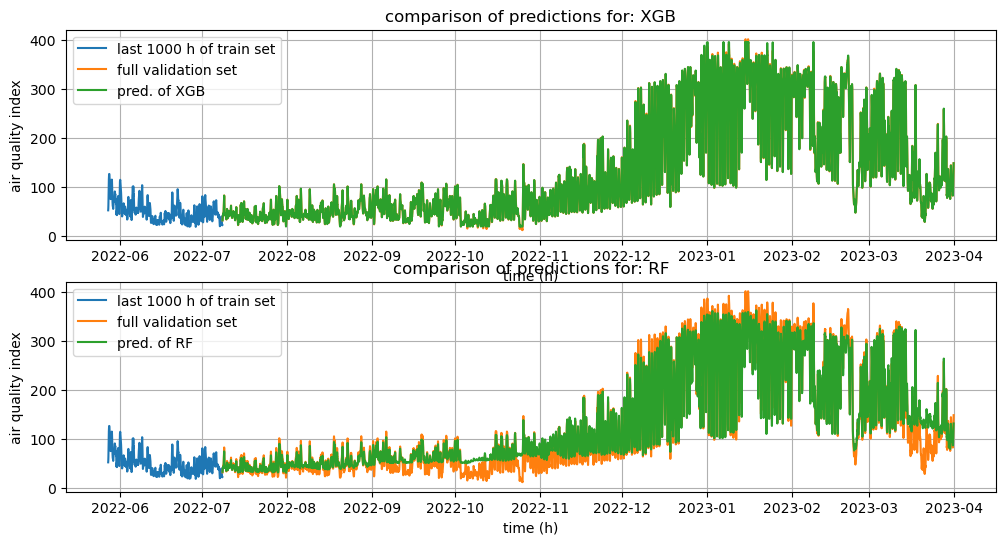

In [48]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
#      visualization and comp. of predictions
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

# table with all algorithms fitted
keys= best_estimators_cu.keys()


print("setting up the figure definitions")
fig, axn= plt.subplots(len(keys),1, figsize= (12,3* len(keys)))


for ax, algo in zip(axn.flat, keys):
    ax.set_title(f"comparison of predictions for: {algo}")
    ax.set_xlabel("time (h)")
    ax.set_ylabel("air quality index")
    sns.lineplot(data= y_train.iloc[-1000:].to_pandas(), label= "last 1000 h of train set", ax= ax)
    sns.lineplot(data= y_test.to_pandas(), label= "full validation set", ax= ax)
    sns.lineplot(data= df_prediction[algo+ "_prediction"].to_pandas(), label= f"pred. of {algo}", ax= ax)
    
    ax.grid()
    ax.legend()

    if verbose_img_save== 1: plt.savefig(results_folder+ f"/004_model_comparison_for_{state}_forecasting.pdf", bbox_inches="tight", transparent=True)

# ::::::::::::::::::::::::::::::::::::::::::::::::::::